In [8]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from KAGGLE_NLP_with_disaster_tweets.data_preparation.utils import DataPipeline
from KAGGLE_NLP_with_disaster_tweets.model import constants

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
train_file_name = 'train.csv'
test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'
max_vocabulary_size = 20000
glove_embedding_dim = 200

data_pipeline = DataPipeline(train_file_name, test_file_name, sample_submission_file_name,
                             output_sequence_length=40,
                             max_vocabulary_size=max_vocabulary_size,
                             glove_embedding_dim=glove_embedding_dim,
                             glove_url=constants.glove_url['twitter.27B'])
dataset = data_pipeline.prepare_train_dataset(include_cols=["keyword", "location"], extract_extras=True)
dataframe = data_pipeline.dataframe

Getting the file: ../data/sample_submission.csv
Getting the file: ../data/train.csv
Dataframe size before eliminating too short texts: 7613
Dataframe size after eliminating too short texts: 7529
         id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7608  10869                    
7609  10870                    
7610  10871                    
7611  10872                    
7612  10873                    

                                                   text  target  
0     our deeds are the reason of this earthquake ma...       1  
1                 forest fire near la ronge sask canada       1  
2     all residents asked to shelter in place are be...       1  
3     13  000 people receive wildfires evacuation or...       1  
4     just got sent this photo from ruby alaska as s...       1  
...                     

## Plot the character count in the tweets

<AxesSubplot:ylabel='Frequency'>

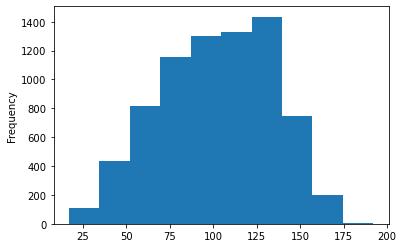

In [10]:
tweet_lengths_by_char = dataframe["text"].map(lambda tweet: len(tweet))
tweet_lengths_by_char.plot(kind='hist')

In [46]:
print(f"Average character count: {tweet_lengths_by_char.sum() / tweet_lengths_by_char.size}")

Average character count: 101.85682029485987


## Plot the word count in the tweets

<AxesSubplot:ylabel='Frequency'>

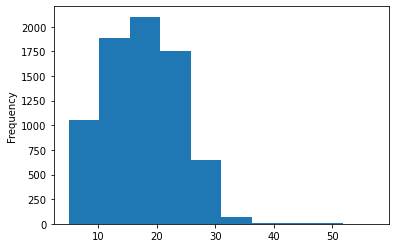

In [12]:
# naive assumption: split words by space char
tweet_lengths_by_word = dataframe["text"].map(lambda tweet: len(tweet.split(" ")))
tweet_lengths_by_word.plot(kind='hist')

In [13]:
print(f"Average word count is: {tweet_lengths_by_word.sum() / tweet_lengths_by_word.size}")

Average word count is: 17.52091911276398


## Plot the class distribution

<AxesSubplot:>

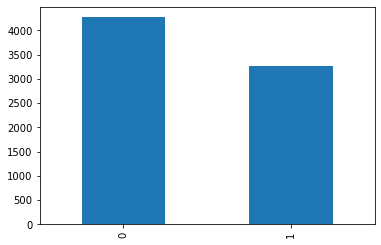

In [14]:
dataframe["target"].value_counts().plot(kind='bar')

### It can be easily seen that the classes are not distributed evenly.

## Check the keyword frequency in the dataset

In [15]:
keywords = dataframe['keyword'].unique().tolist()
keyword_counts = {}
keywords_by_labels = []
for keyword in keywords:
    keyword_counts[keyword] = dataframe['keyword'].where(dataframe['keyword'] == keyword).count()
    keywords_by_labels.append({
        'keyword': keyword,
        'true': dataframe.where((dataframe['keyword'] == keyword) & (dataframe['target'] == 1))['id'].count(),
        'false': dataframe.where((dataframe['keyword'] == keyword) & (dataframe['target'] == 0))['id'].count()
    })
print(keyword_counts)

{'': 46, 'ablaze': 36, 'accident': 35, 'aftershock': 32, 'airplane accident': 35, 'ambulance': 38, 'annihilated': 34, 'annihilation': 29, 'apocalypse': 31, 'armageddon': 41, 'army': 34, 'arson': 32, 'arsonist': 33, 'attack': 36, 'attacked': 35, 'avalanche': 30, 'battle': 26, 'bioterror': 37, 'bioterrorism': 30, 'blaze': 38, 'blazing': 34, 'bleeding': 35, 'blew up': 33, 'blight': 31, 'blizzard': 35, 'blood': 34, 'bloody': 35, 'blown up': 33, 'body bag': 33, 'body bagging': 33, 'body bags': 41, 'bomb': 34, 'bombed': 38, 'bombing': 29, 'bridge collapse': 35, 'buildings burning': 35, 'buildings on fire': 33, 'burned': 33, 'burning': 34, 'burning buildings': 37, 'bush fires': 25, 'casualties': 35, 'casualty': 33, 'catastrophe': 36, 'catastrophic': 30, 'chemical emergency': 33, 'cliff fall': 36, 'collapse': 34, 'collapsed': 34, 'collide': 34, 'collided': 40, 'collision': 39, 'crash': 33, 'crashed': 34, 'crush': 37, 'crushed': 29, 'curfew': 37, 'cyclone': 32, 'damage': 41, 'danger': 36, 'dead

<AxesSubplot:>

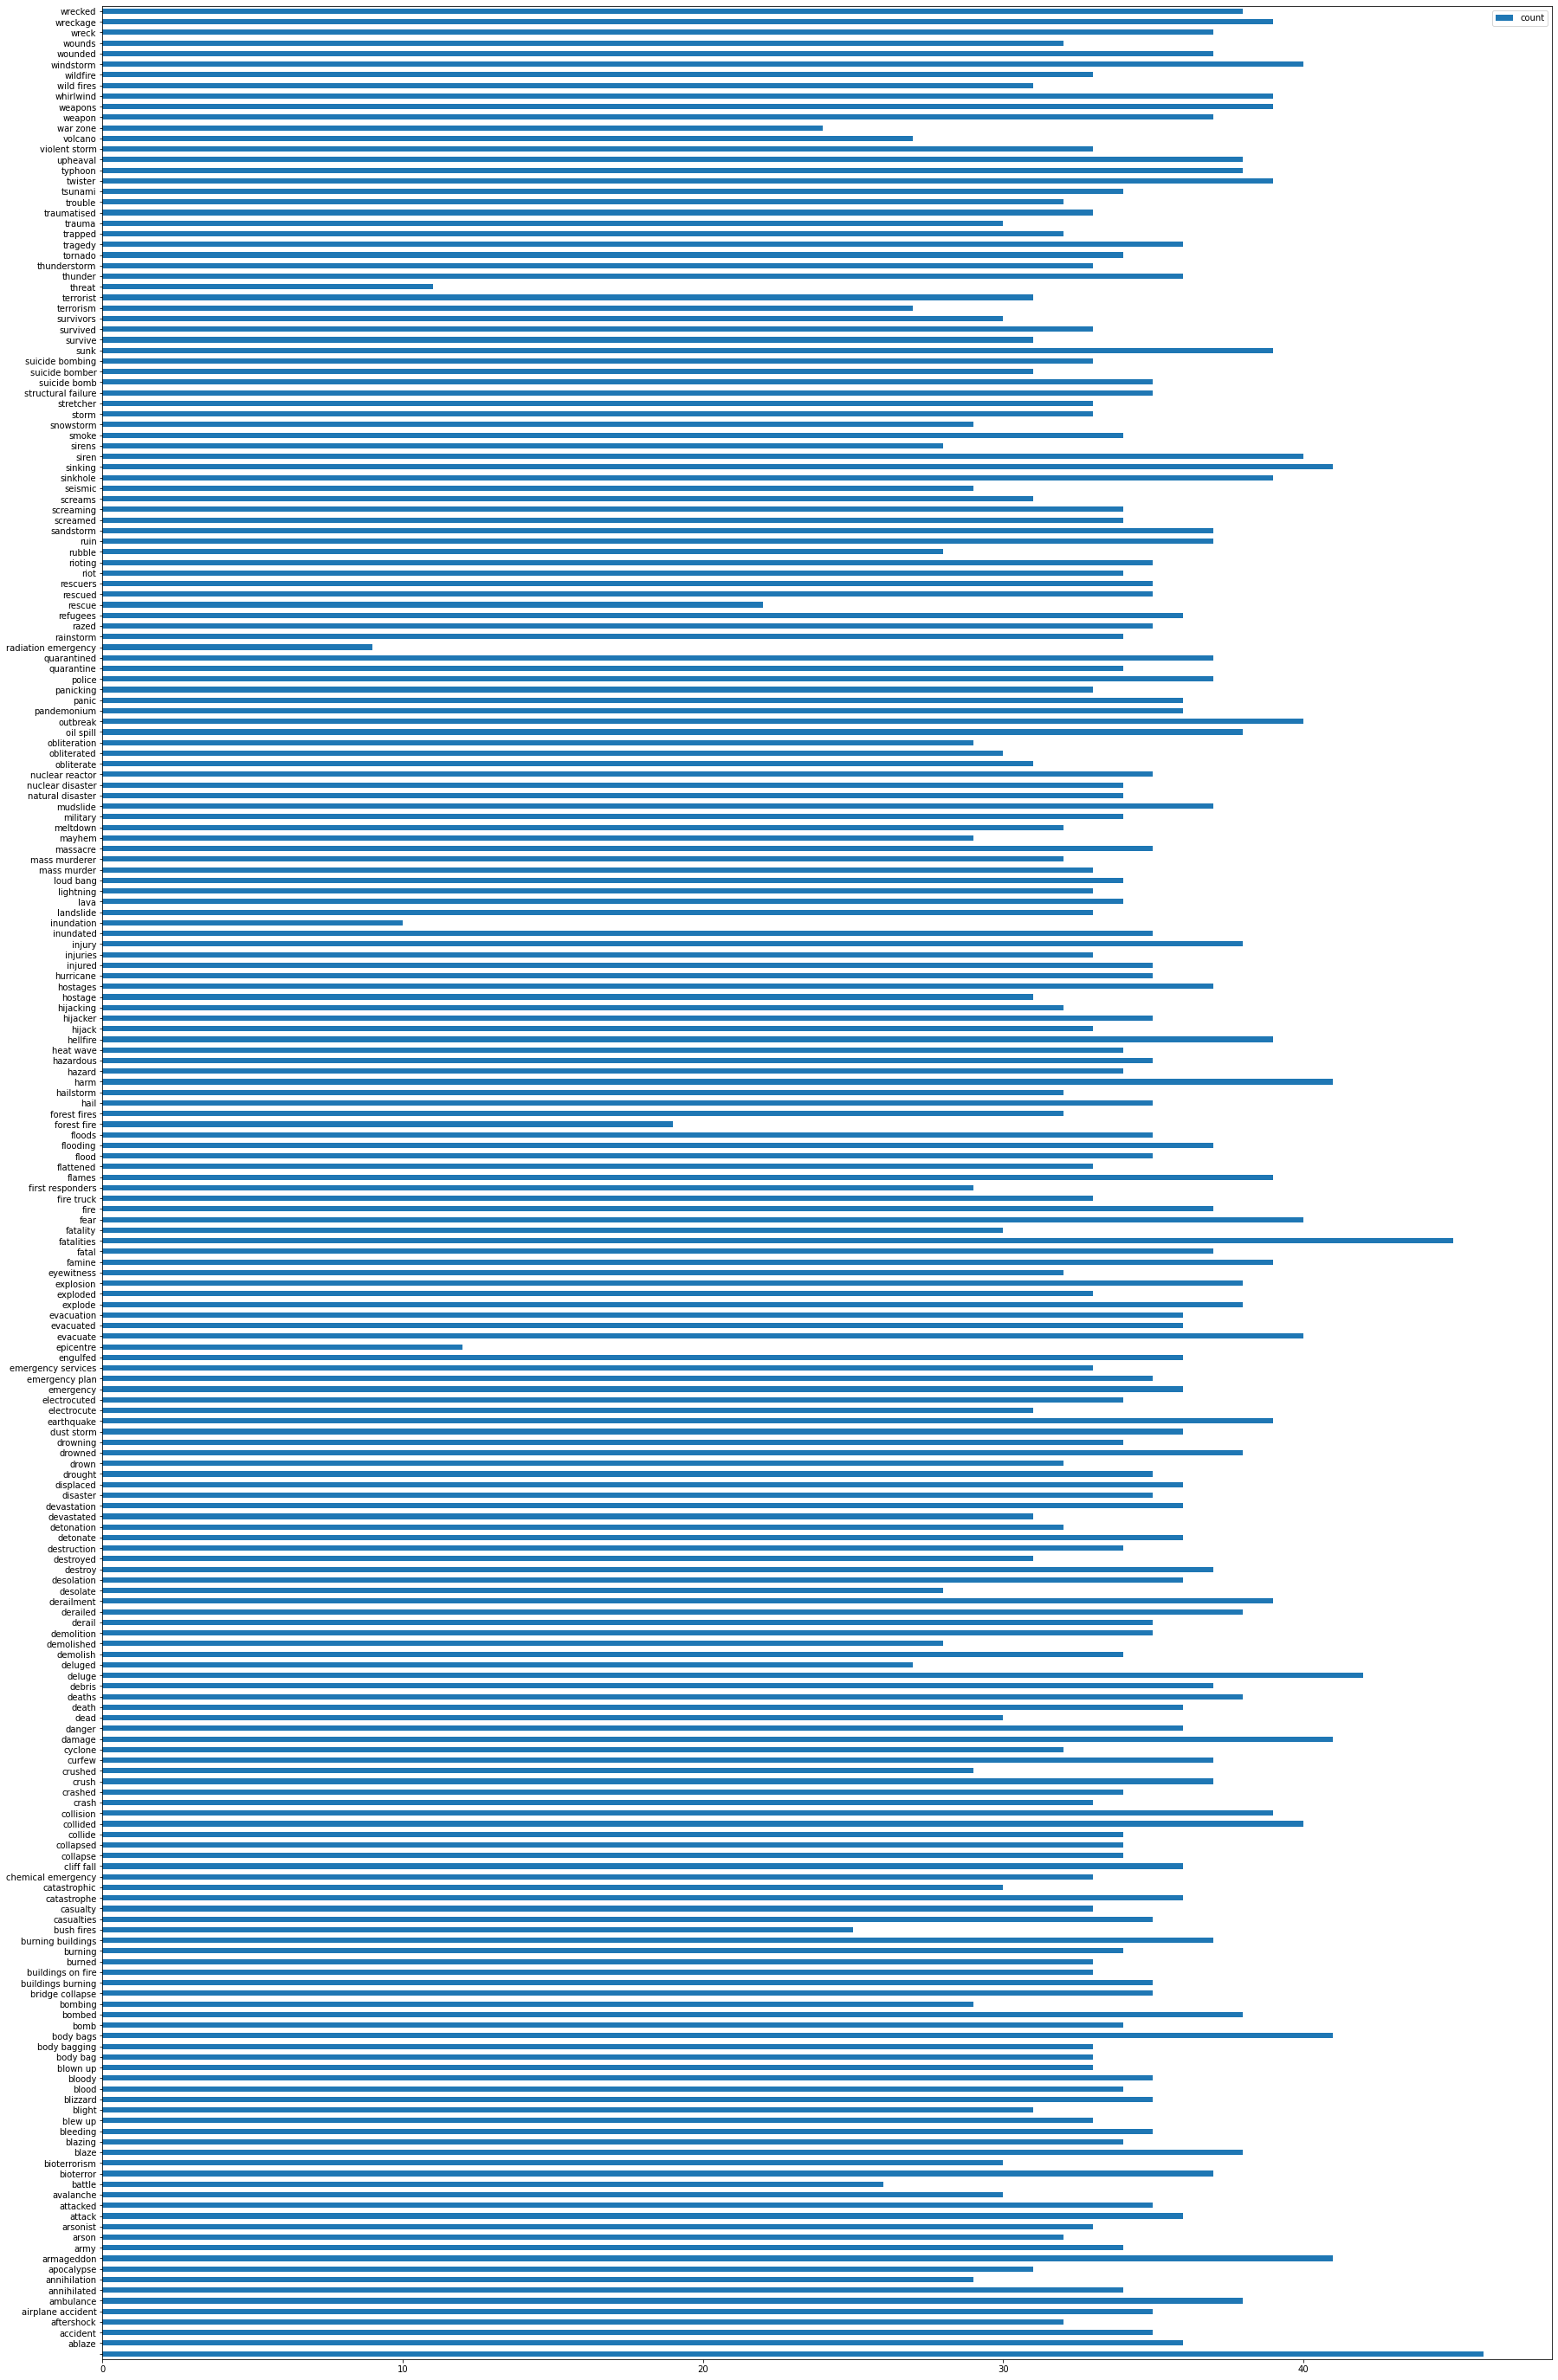

In [16]:
keyword_count_df = pd.DataFrame({"keyword": keyword_counts.keys(), "count": keyword_counts.values()}, index=keyword_counts.keys())
keyword_count_df.plot.barh(figsize=(30, 50))


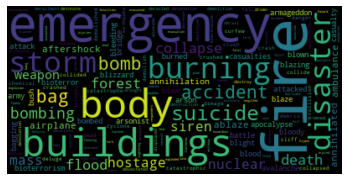

In [18]:
wordcloud = WordCloud().generate("\n".join(keywords))
# good way to quickly get the understanding of the corpus at hand
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");


In [19]:
df = pd.DataFrame(keywords_by_labels)

In [20]:
df


,keyword,true,false
0,,41,5
1,ablaze,13,23
2,accident,24,11
3,aftershock,0,32
4,airplane accident,30,5
...,...,...,...
217,wounded,26,11
218,wounds,10,22
219,wreck,7,30
220,wreckage,39,0


In [21]:
import math

def visualize_keywords_by_labels(df: pd.DataFrame, num_figs: int):
    step_size = math.ceil(len(df) / num_figs)
    category_names = ["true", "false"]
    category_colors = ["green", "red"]
    text_colors = ["darkgrey", "white"]
    fig, axs = plt.subplots(num_figs)
    # first slice the dataframe into num_figs parts
    for i in range(0, num_figs):
        sliced_df = df[i*step_size:(i+1)*step_size]
        data = np.array(sliced_df[category_names].values)
        sliced_keywords = sliced_df.keyword.values

        axs[i].invert_yaxis()
        for j, (colname, color) in enumerate(zip(category_names, category_colors)):
            # get the sum of the row
            cumulative_sum = data.cumsum(axis=1)
            widths = data[:, j]
            # start width
            starts = cumulative_sum[:, j] - widths
            # add bars
            rects = axs[i].barh(sliced_keywords, widths, left=starts, height=0.8, label=colname, color=color)
            axs[i].bar_label(rects, label_type='center', padding=0.1, color=text_colors[j])
        axs[i].legend(ncol=len(category_names), bbox_to_anchor=(0, 1), loc='lower right', fontsize='small')


        # axs[i]
    fig.set_size_inches(10, 30, forward=True)
    plt.show()

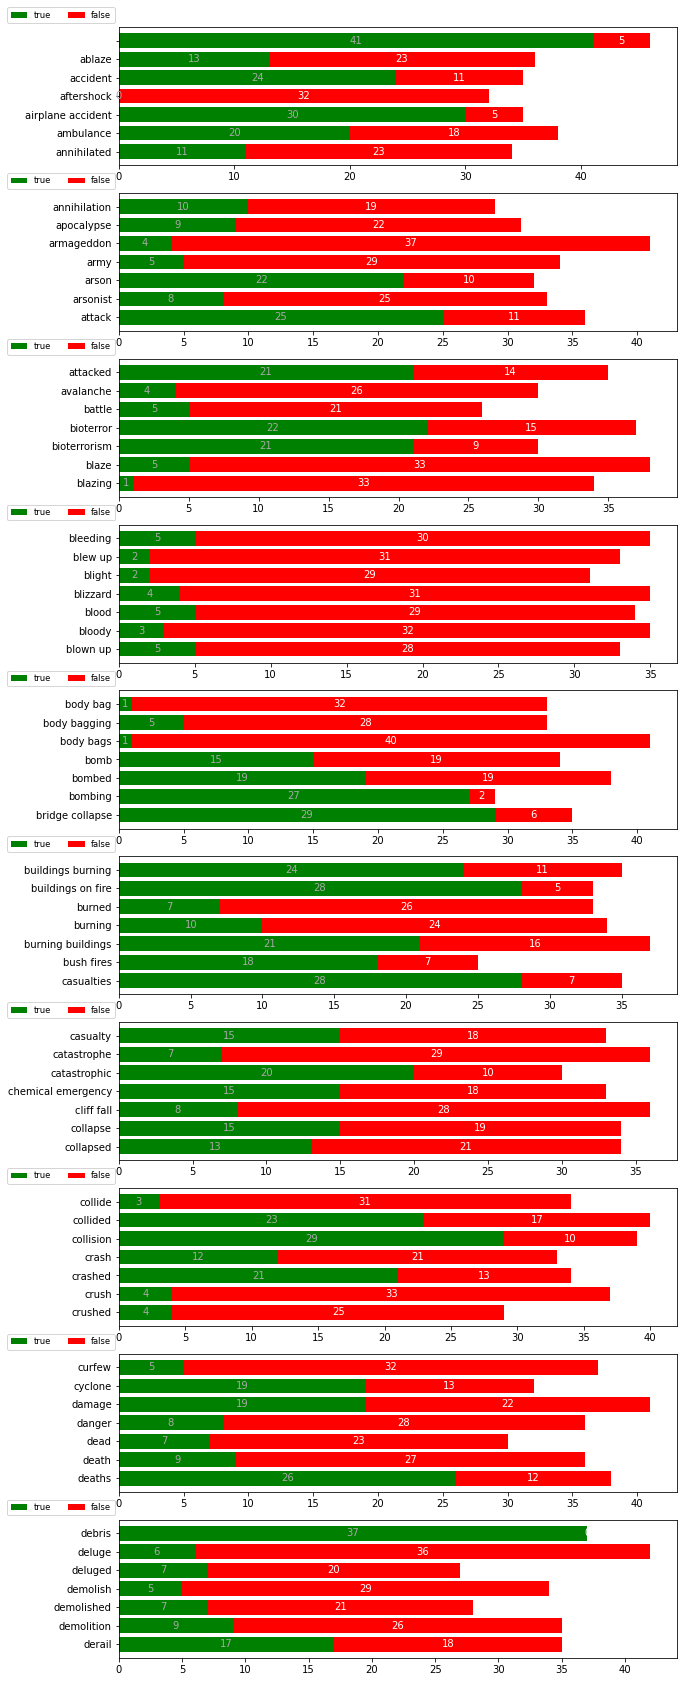

In [22]:
visualize_keywords_by_labels(df[0:70], 10)

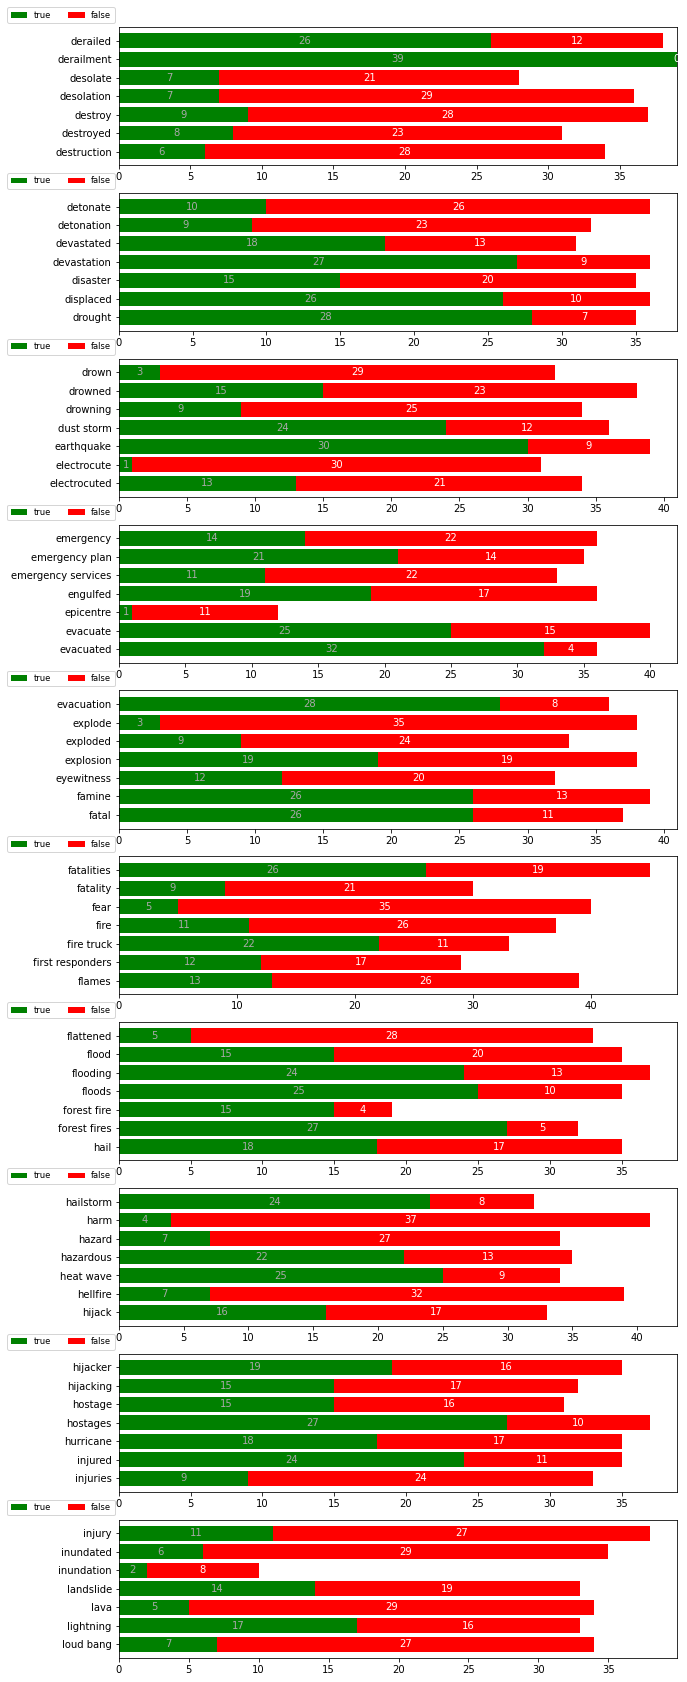

In [23]:
visualize_keywords_by_labels(df[70:140], 10)


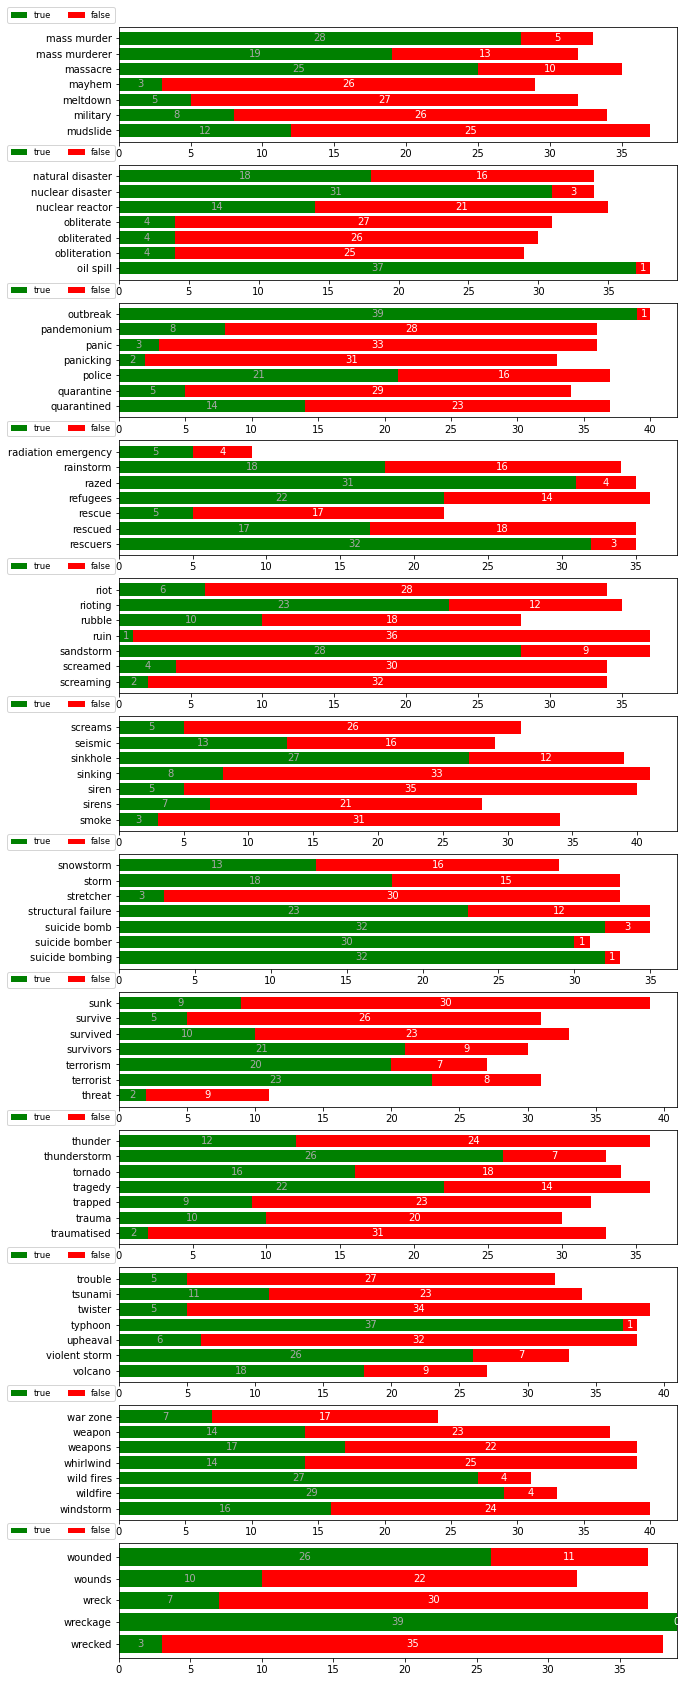

In [24]:
visualize_keywords_by_labels(df[140:], 12)


In [43]:
# we want to see the length of each input after vectorization
dataset_inputs = dataset.map(lambda x, y: x)
inputs_dataframe = pd.DataFrame(dataset_inputs.as_numpy_iterator())
inputs_len_list = []
# truncate the list at the first occurrence of 0
for idx, row in inputs_dataframe.iterrows():
    try:
        end_idx = row.values.tolist().index(0)
        input_len = len(row.values[0:end_idx])
    except ValueError:
        input_len = len(row.values)
    inputs_len_list.append(input_len)
# convert to df for convenience
inputs_len_list = pd.DataFrame({'len': inputs_len_list})

<AxesSubplot:>

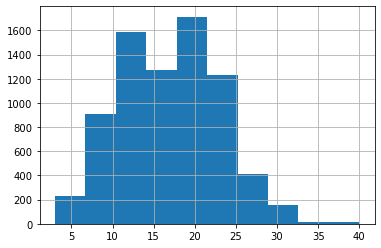

In [44]:
inputs_len_list['len'].hist()

In [45]:
print(f"The average token count: {inputs_len_list['len'].sum() / inputs_len_list.size}")

The average token count: 17.020321423827866


In [34]:
inputs_len_list.size


7529

In [40]:
inputs_len_list.sum(axis=0).values


array([128146])